In [ ]:
!pip install numpy pygad scikit-learn requests matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pythonafroz/solar-powe-generation-data")

print("Path to dataset files:", path)

100%|██████████| 111k/111k [00:00<00:00, 50.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pythonafroz/solar-powe-generation-data/versions/6


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make graphs look nice
plt.style.use('ggplot')

# 1. Load the Data
df = pd.read_csv('/content/drive/MyDrive/CI/Solar Power Plant Data.csv')


print(f"Data Loaded. Shape: {df.shape}")
print("First 5 rows:")
display(df.head()) # 'display()' makes it look pretty in Jupyter

Data Loaded. Shape: (8760, 8)
First 5 rows:


,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.6,0,1003.8,-7.4,0.1,97,0.0
1,01.01.2017-01:00,1.7,0,1003.5,-7.4,-0.2,98,0.0
2,01.01.2017-02:00,0.6,0,1003.4,-6.7,-1.2,99,0.0
3,01.01.2017-03:00,2.4,0,1003.3,-7.2,-1.3,99,0.0
4,01.01.2017-04:00,4.0,0,1003.1,-6.3,3.6,67,0.0


In [18]:

# 1. Convert columns to Numeric
cols_numeric = ['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation',
                'AirTemperature', 'RelativeAirHumidity', 'SystemProduction']

for col in cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Check for Missing Values BEFORE cleaning
print("Missing values before cleaning:")
print(df.isnull().sum())

# 3. Fill Missing Values (Interpolation)
df[cols_numeric] = df[cols_numeric].interpolate(method='linear', limit_direction='both')

# 4. Remove Negative Logic Errors
if 'SystemProduction' in df.columns:
    df['SystemProduction'] = df['SystemProduction'].clip(lower=0)
if 'WindSpeed' in df.columns:
    df['WindSpeed'] = df['WindSpeed'].clip(lower=0)

# Final Check
print("\nMissing values AFTER cleaning:")
print(df.isnull().sum().sum())

Missing values before cleaning:
Date-Hour(NMT)         0
WindSpeed              0
Sunshine               0
AirPressure            0
Radiation              0
AirTemperature         0
RelativeAirHumidity    0
SystemProduction       0
dtype: int64

Missing values AFTER cleaning:
0


In [19]:
import pandas as pd

# ==========================================
# 1. PARSE DATES (With Strict Checks)
# ==========================================
print("--- Step 1: Parsing Dates ---")

# Convert using dayfirst=True because your format is dd.mm.yyyy
# errors='coerce' will turn any unreadable text into NaT (Not a Time)
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], dayfirst=True, errors='coerce')

# CHECK: Did any rows fail to convert?
failed_rows = df['Date-Hour(NMT)'].isnull().sum()
if failed_rows > 0:
    print(f"WARNING: {failed_rows} rows failed to parse and are now empty (NaT).")
    # Option: Drop them if they are broken
    df = df.dropna(subset=['Date-Hour(NMT)'])
    print(f"   -> Dropped failed rows. New count: {len(df)}")
else:
    print("All dates parsed successfully.")

print("Date Column Type:", df['Date-Hour(NMT)'].dtype)
print("Sample Date:", df['Date-Hour(NMT)'].iloc[0])


# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================
print("\n--- Step 2: Extracting Features ---")

df['Hour'] = df['Date-Hour(NMT)'].dt.hour       # Should be 0-23
df['Month'] = df['Date-Hour(NMT)'].dt.month     # Should be 1-12
df['DayOfYear'] = df['Date-Hour(NMT)'].dt.dayofyear

# CHECK: Are the extracted features valid?
print(f"Unique Hours found: {sorted(df['Hour'].unique())}")
# You expect: [0, 1, 2, ... 23]
print(f"Unique Months found: {sorted(df['Month'].unique())}")
# You expect: [1, 2, ... 12] (if dataset covers full year)


# ==========================================
# 3. SET INDEX & FINALIZE
# ==========================================
print("\n--- Step 3: Setting Index ---")

df.set_index('Date-Hour(NMT)', inplace=True)

# Final Visual Check
print(f"Total Rows: {len(df)}")
display(df[['Hour', 'Month', 'SystemProduction']].head())

# Double check there are no NaNs in the critical columns needed for AI
nulls = df[['Hour', 'Month', 'SystemProduction']].isnull().sum()
if nulls.sum() == 0:
    print("\nDATA READY: No missing values in input columns.")
else:
    print("\nWARNING: Remaining missing values:")
    print(nulls)

--- Step 1: Parsing Dates ---
All dates parsed successfully.
Date Column Type: datetime64[ns]
Sample Date: 2017-01-01 00:00:00

--- Step 2: Extracting Features ---
Unique Hours found: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23)]
Unique Months found: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]

--- Step 3: Setting Index ---
Total Rows: 8760


,Hour,Month,SystemProduction
Date-Hour(NMT),,,
2017-01-01 00:00:00,0,1,0.0
2017-01-01 01:00:00,1,1,0.0
2017-01-01 02:00:00,2,1,0.0
2017-01-01 03:00:00,3,1,0.0
2017-01-01 04:00:00,4,1,0.0



DATA READY: No missing values in input columns.


Dataset Statistics:


,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Hour,Month,DayOfYear
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2.639823,11.180479,1010.361781,97.538493,6.978893,76.719406,684.746071,11.500000,6.526027,183.000000
std,1.628754,21.171295,12.793971,182.336029,7.604266,19.278996,1487.454665,6.922582,3.448048,105.372043
min,0.000000,0.000000,965.900000,-9.300000,-12.400000,13.000000,0.000000,0.000000,1.000000,1.000000
25%,1.400000,0.000000,1002.800000,-6.200000,0.500000,64.000000,0.000000,5.750000,4.000000,92.000000
50%,2.300000,0.000000,1011.000000,-1.400000,6.400000,82.000000,0.000000,11.500000,7.000000,183.000000
75%,3.600000,7.000000,1018.200000,115.600000,13.400000,93.000000,464.249950,17.250000,10.000000,274.000000
max,10.900000,60.000000,1047.300000,899.700000,27.100000,100.000000,7701.000000,23.000000,12.000000,365.000000


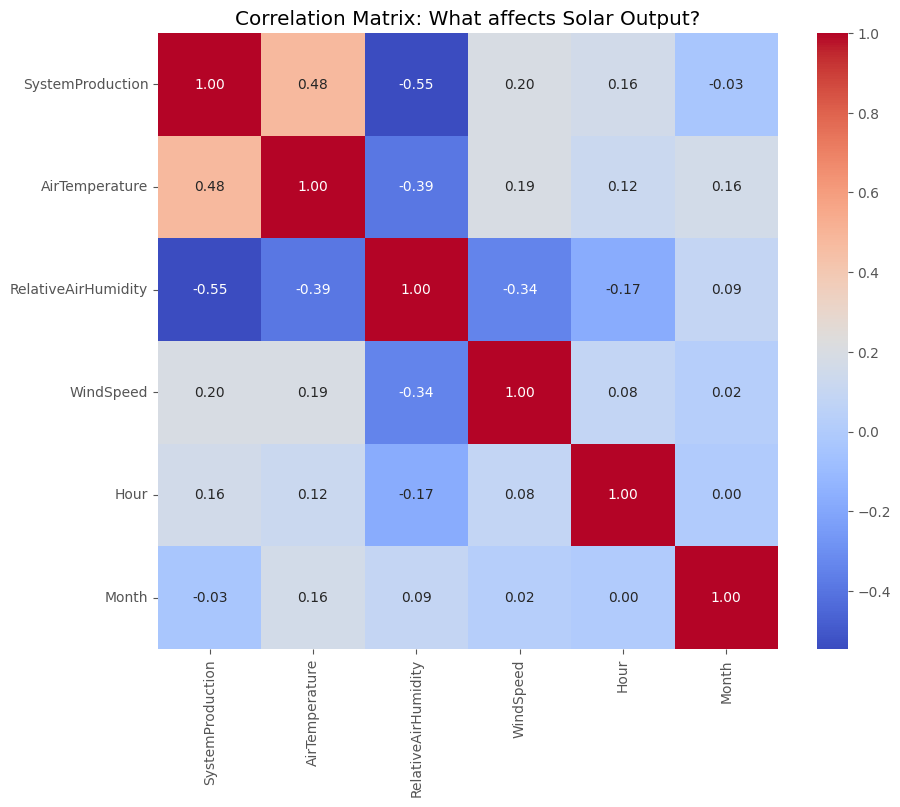

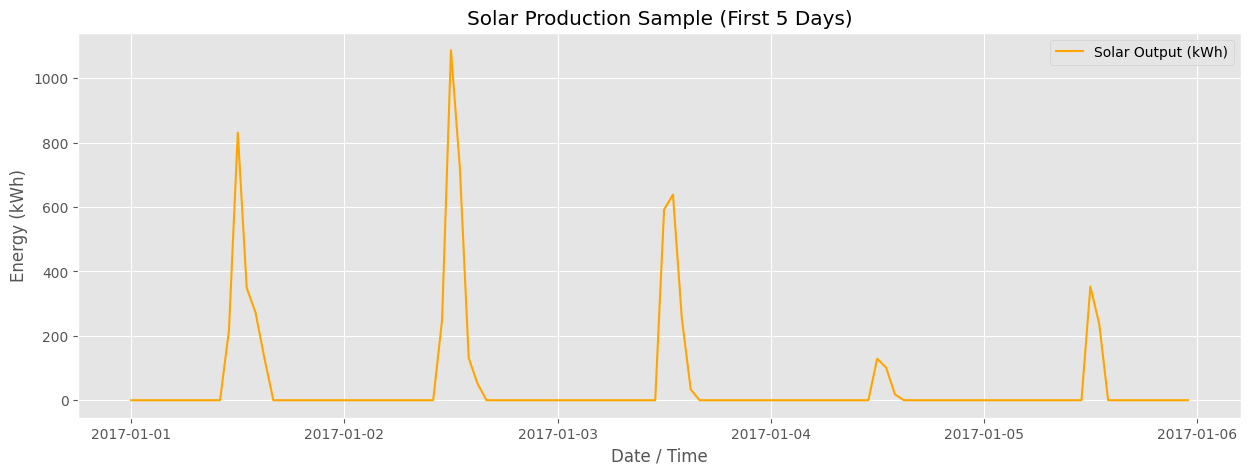

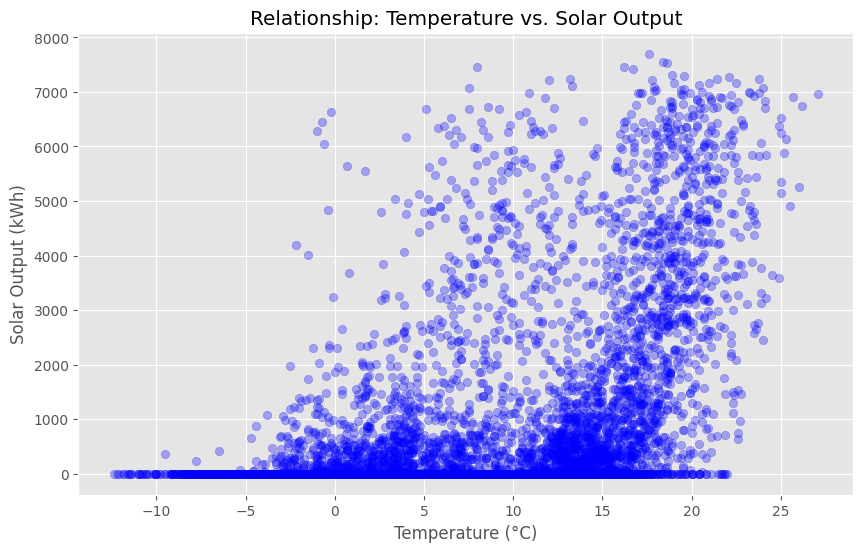

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. STATISTICS & CORRELATION
# ==========================================
print("Dataset Statistics:")
display(df.describe())

# Define the columns we want to check for patterns
# We include 'Hour' and 'Month' because they are crucial for Solar
cols_to_check = ['SystemProduction', 'AirTemperature', 'RelativeAirHumidity', 'WindSpeed', 'Hour', 'Month']

# Calculate Correlation
# (Only using columns that actually exist in your dataframe to avoid errors)
valid_cols = [c for c in cols_to_check if c in df.columns]
corr = df[valid_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: What affects Solar Output?")
plt.show()

# ==========================================
# 2. TIME SERIES PLOT (First 5 Days)
# ==========================================
plt.figure(figsize=(15, 5))

# Since the Index is now the Date-Time, plotting directly uses it for the X-axis
plt.plot(df.index[:120], df['SystemProduction'].iloc[:120], label='Solar Output (kWh)', color='orange')

plt.title("Solar Production Sample (First 5 Days)")
plt.xlabel("Date / Time")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 3. SCATTER PLOT (Temperature vs Energy)
# ==========================================
plt.figure(figsize=(10, 6))

# Using 'AirTemper' because that is the name in your CSV
plt.scatter(df['AirTemperature'], df['SystemProduction'], alpha=0.3, color='blue')

plt.title("Relationship: Temperature vs. Solar Output")
plt.xlabel("Temperature (°C)")
plt.ylabel("Solar Output (kWh)")
plt.grid(True)
plt.show()

In [23]:
# Save the cleaned dataset to a new CSV file
# 'index=True' keeps the Date-Hour column we worked so hard to fix
df.to_csv("/content/drive/MyDrive/CI/cleaned_solar_data.csv", index=True)

print(" Data saved")

 Data saved
